In [1]:
!nvidia-smi

Tue Aug  1 19:48:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow

We pull the dataset we prepared in Roboflow here.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("fikretulus").project("football-players-detection-bjzew")
dataset = project.version(3).download("yolov8")

We start to train our model

In [10]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=50 imgsz=800 plots=True

/content
100% 21.5M/21.5M [00:00<00:00, 23.0MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/Football-Players-Detection-3/data.yaml, epochs=50, patience=50, batch=16, imgsz=800, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, f

Let's take a look at the results

In [ ]:
!ls {HOME}/runs/detect/train/

/content


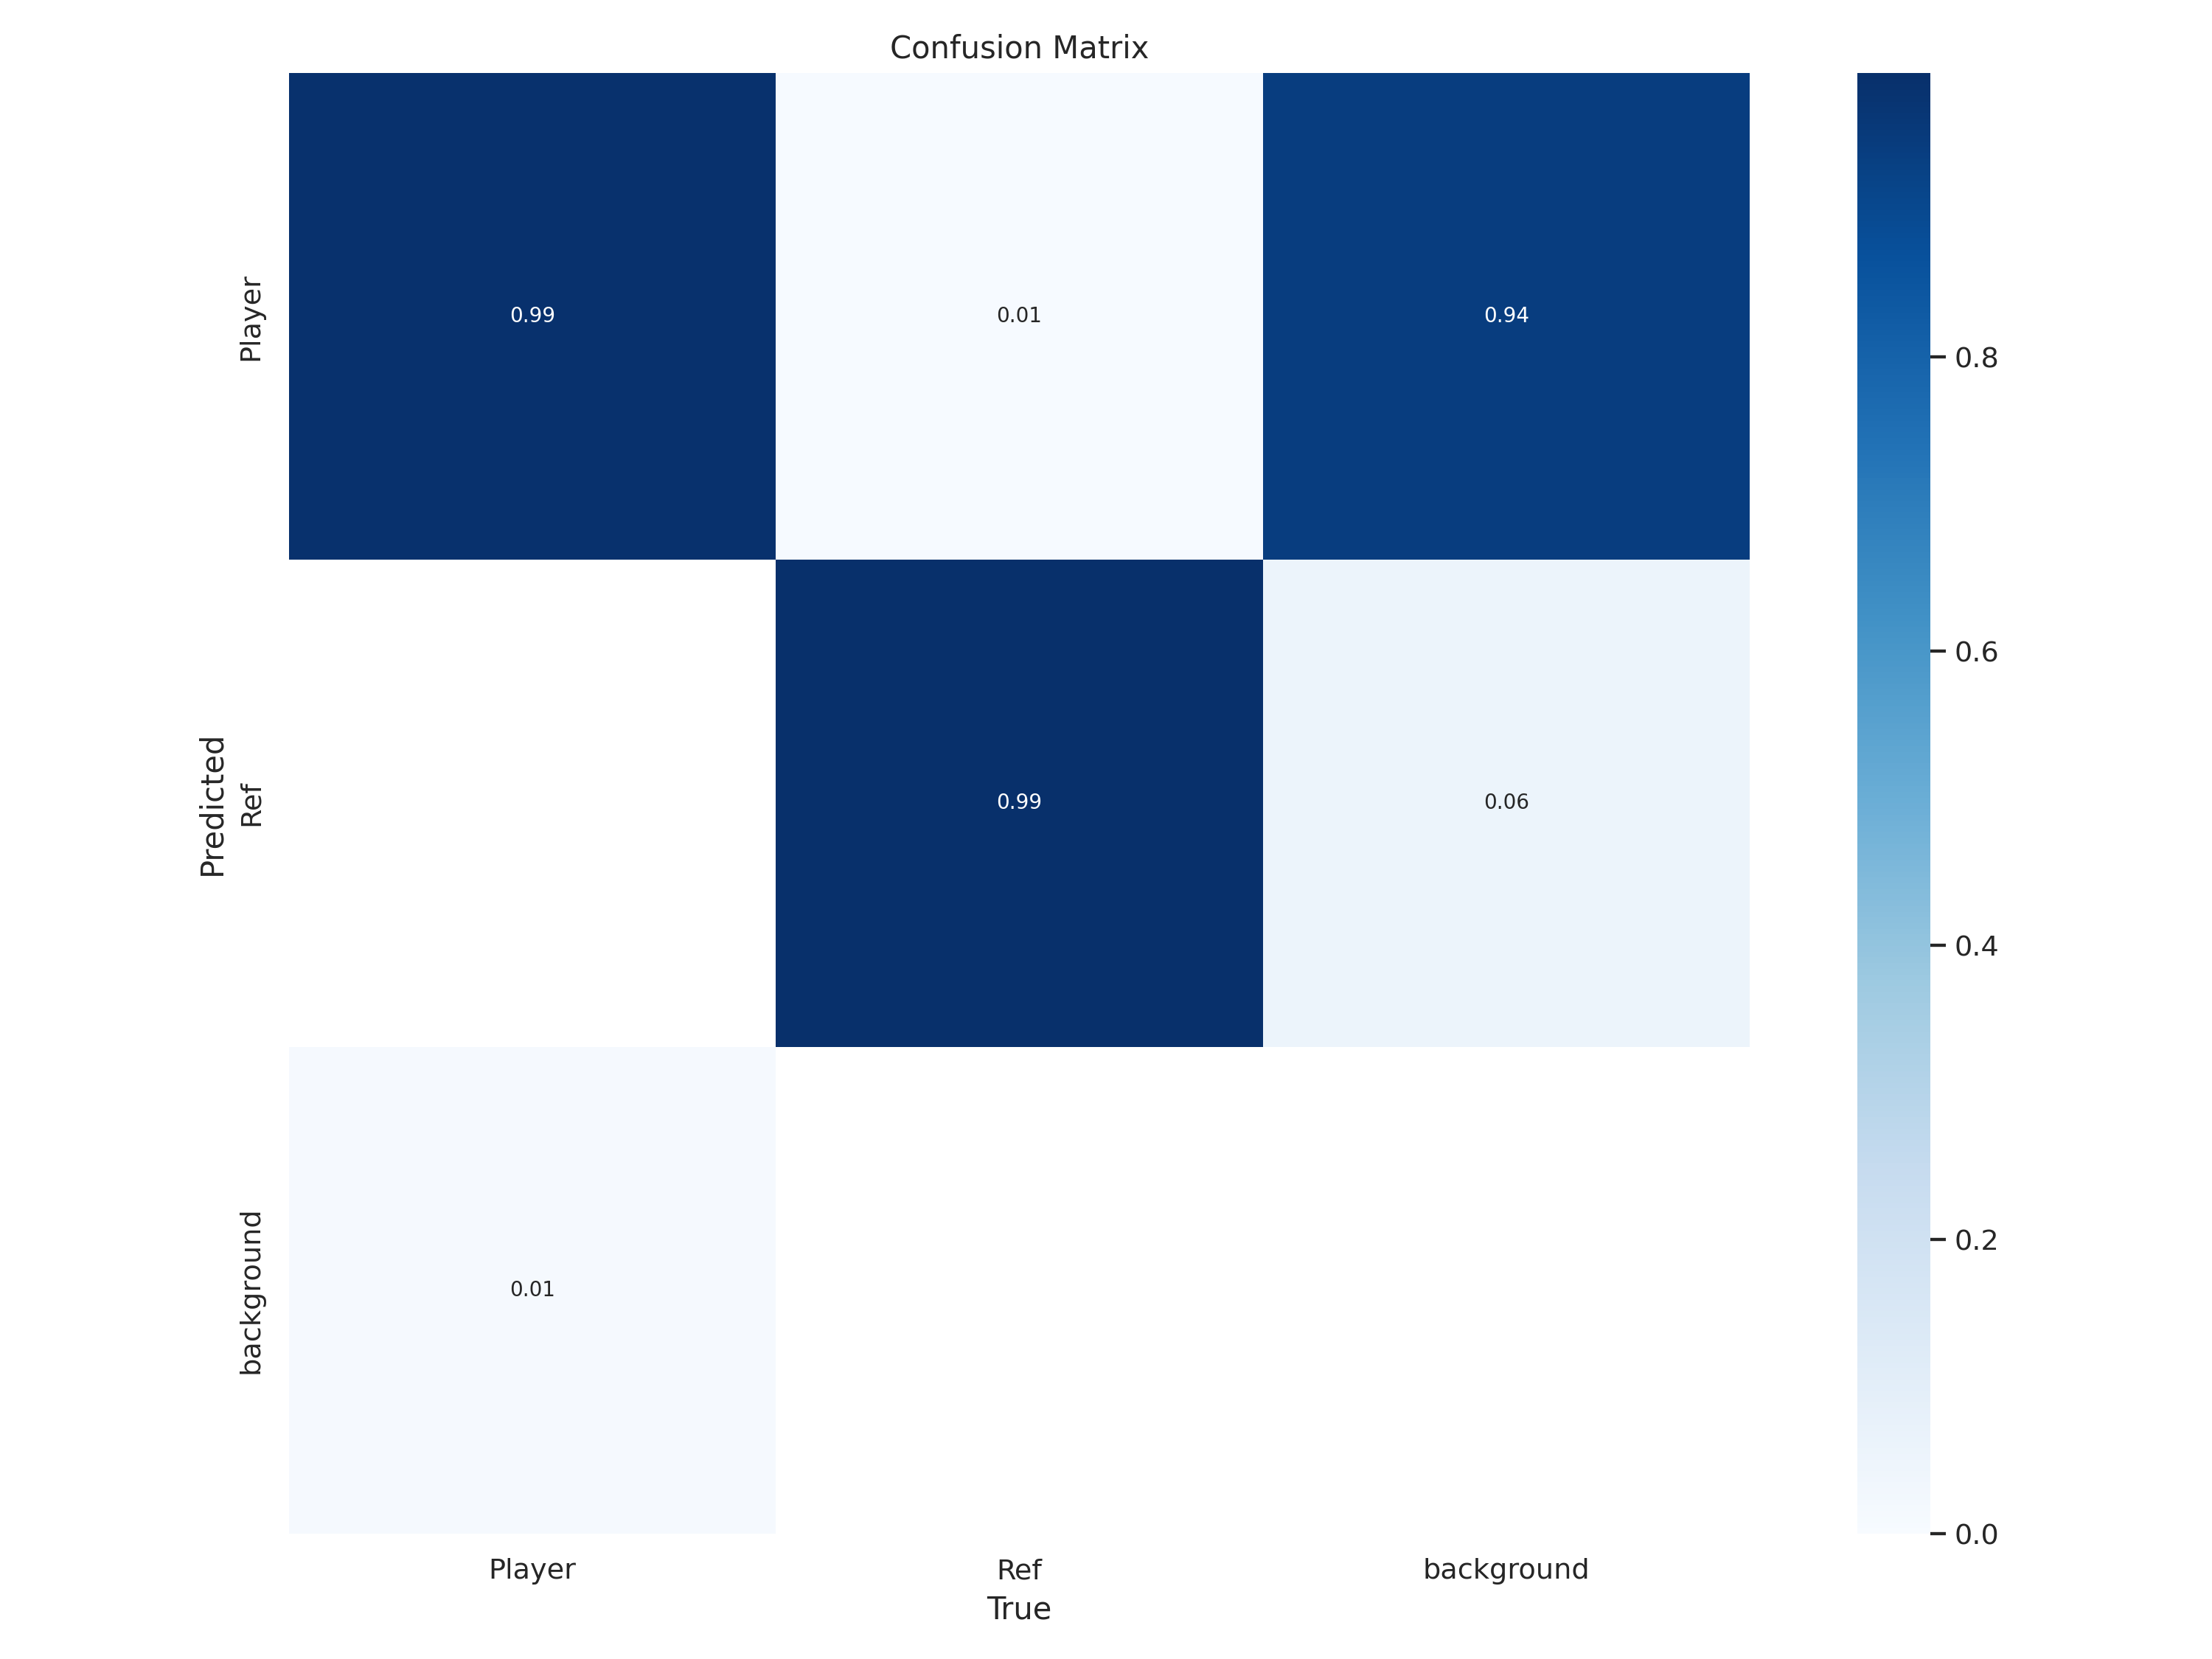

In [14]:
from IPython.display import display, Image
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

According to Confusion Matrix, our model looks quite successful. Nevertheless, it would not be correct to make an evaluation based on this alone. Therefore, we need to take a look at the other graphs.

/content


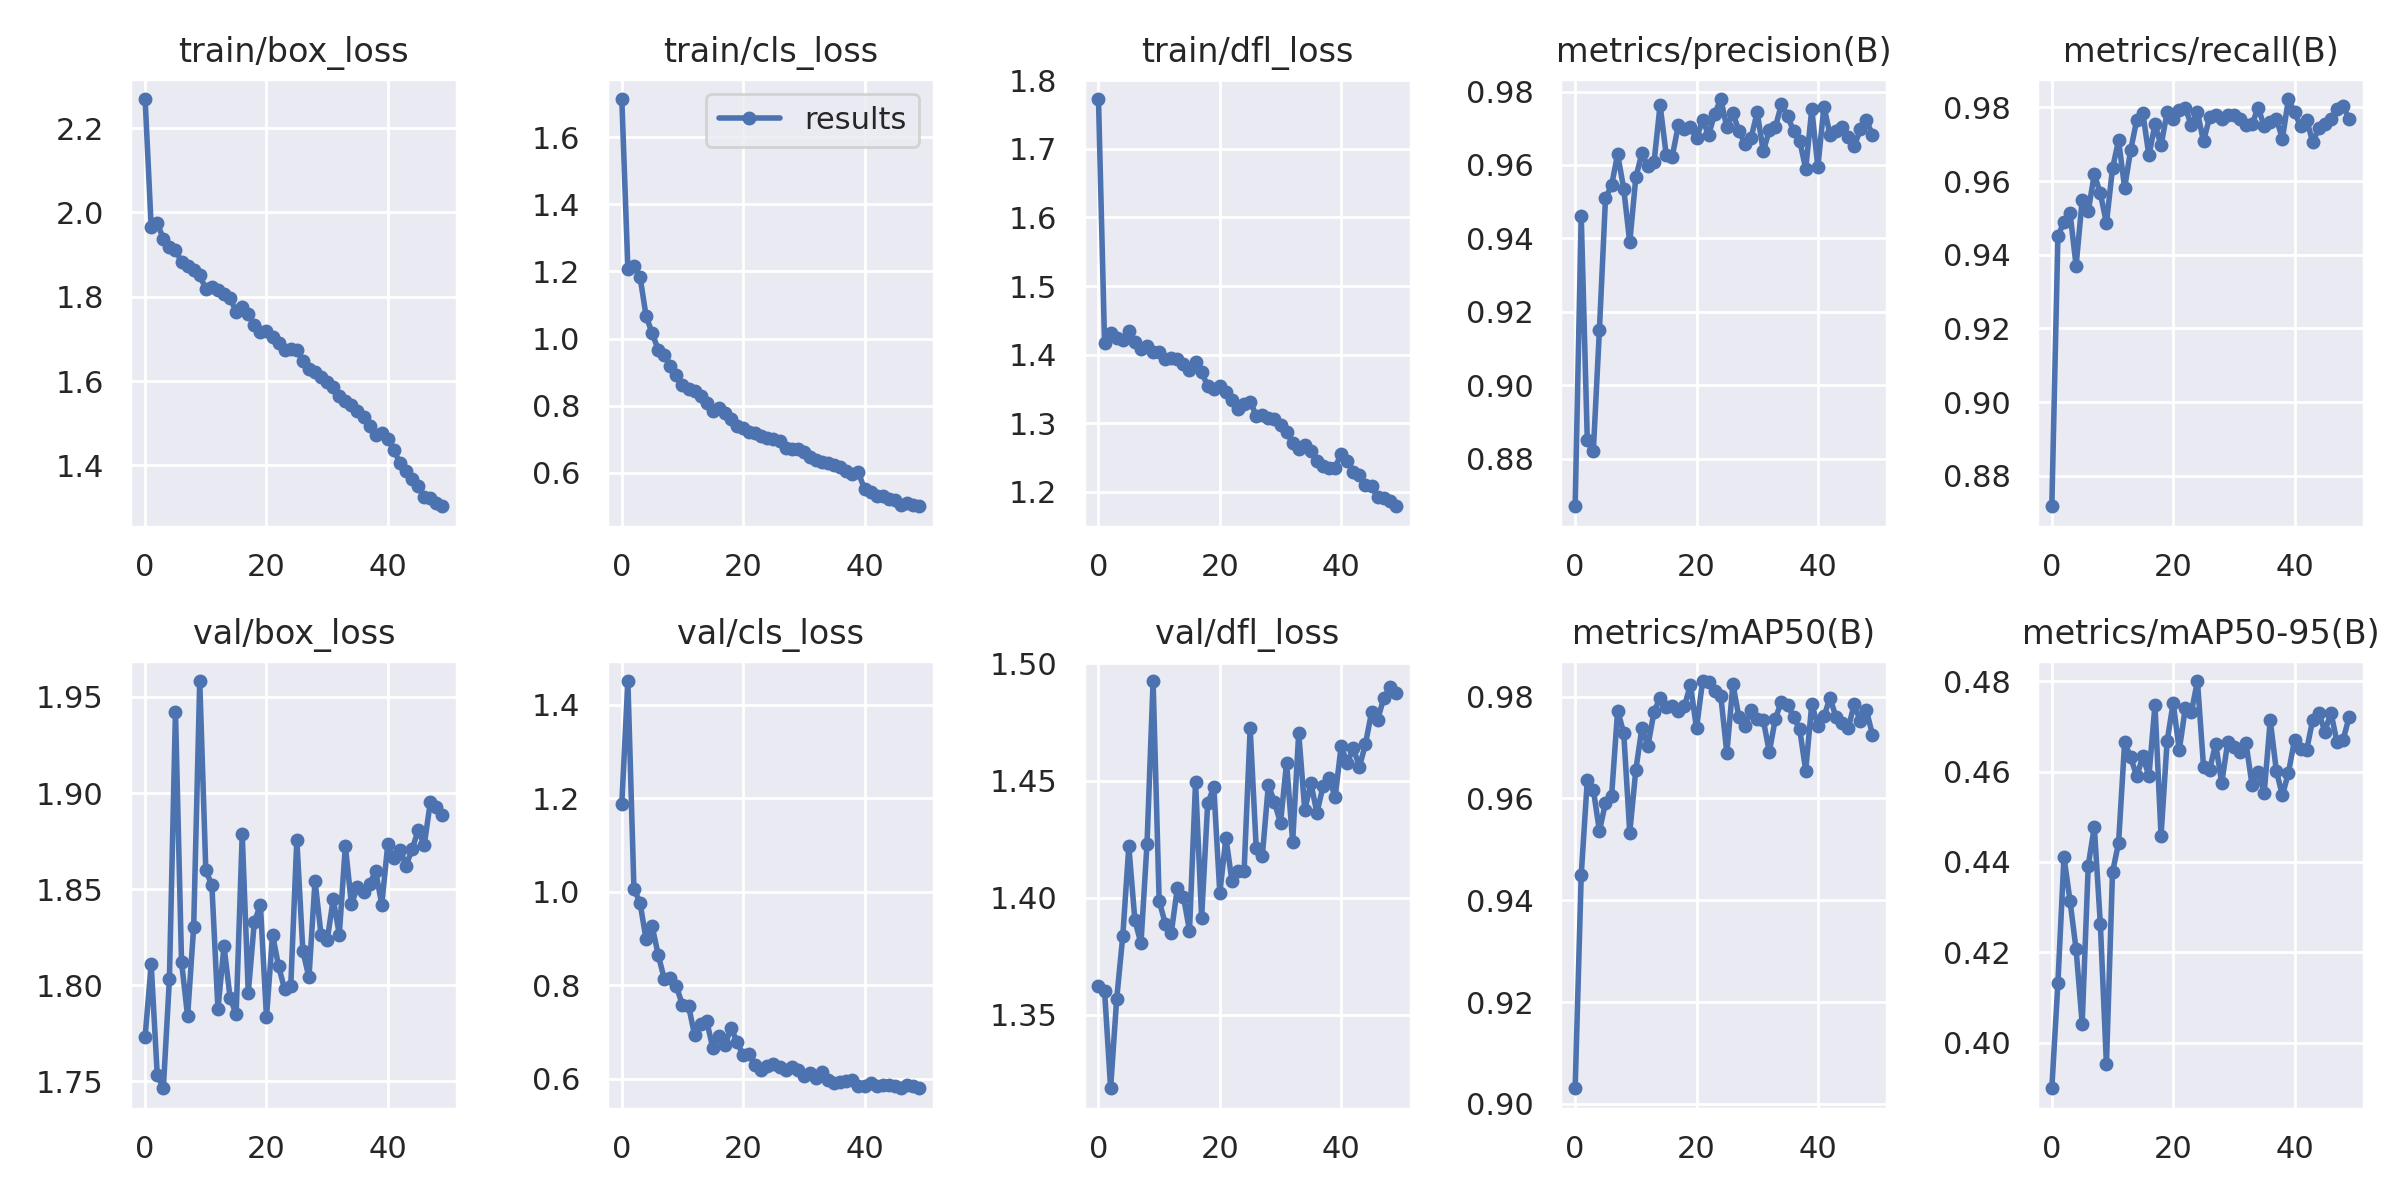

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

The train/box_loss and train/cl_loss graphs are as they should be. However, looking at the orientation of the graph, it seems possible to obtain a more successful model by increasing the number of epochs.

Let's take a look at the prediction images

/content


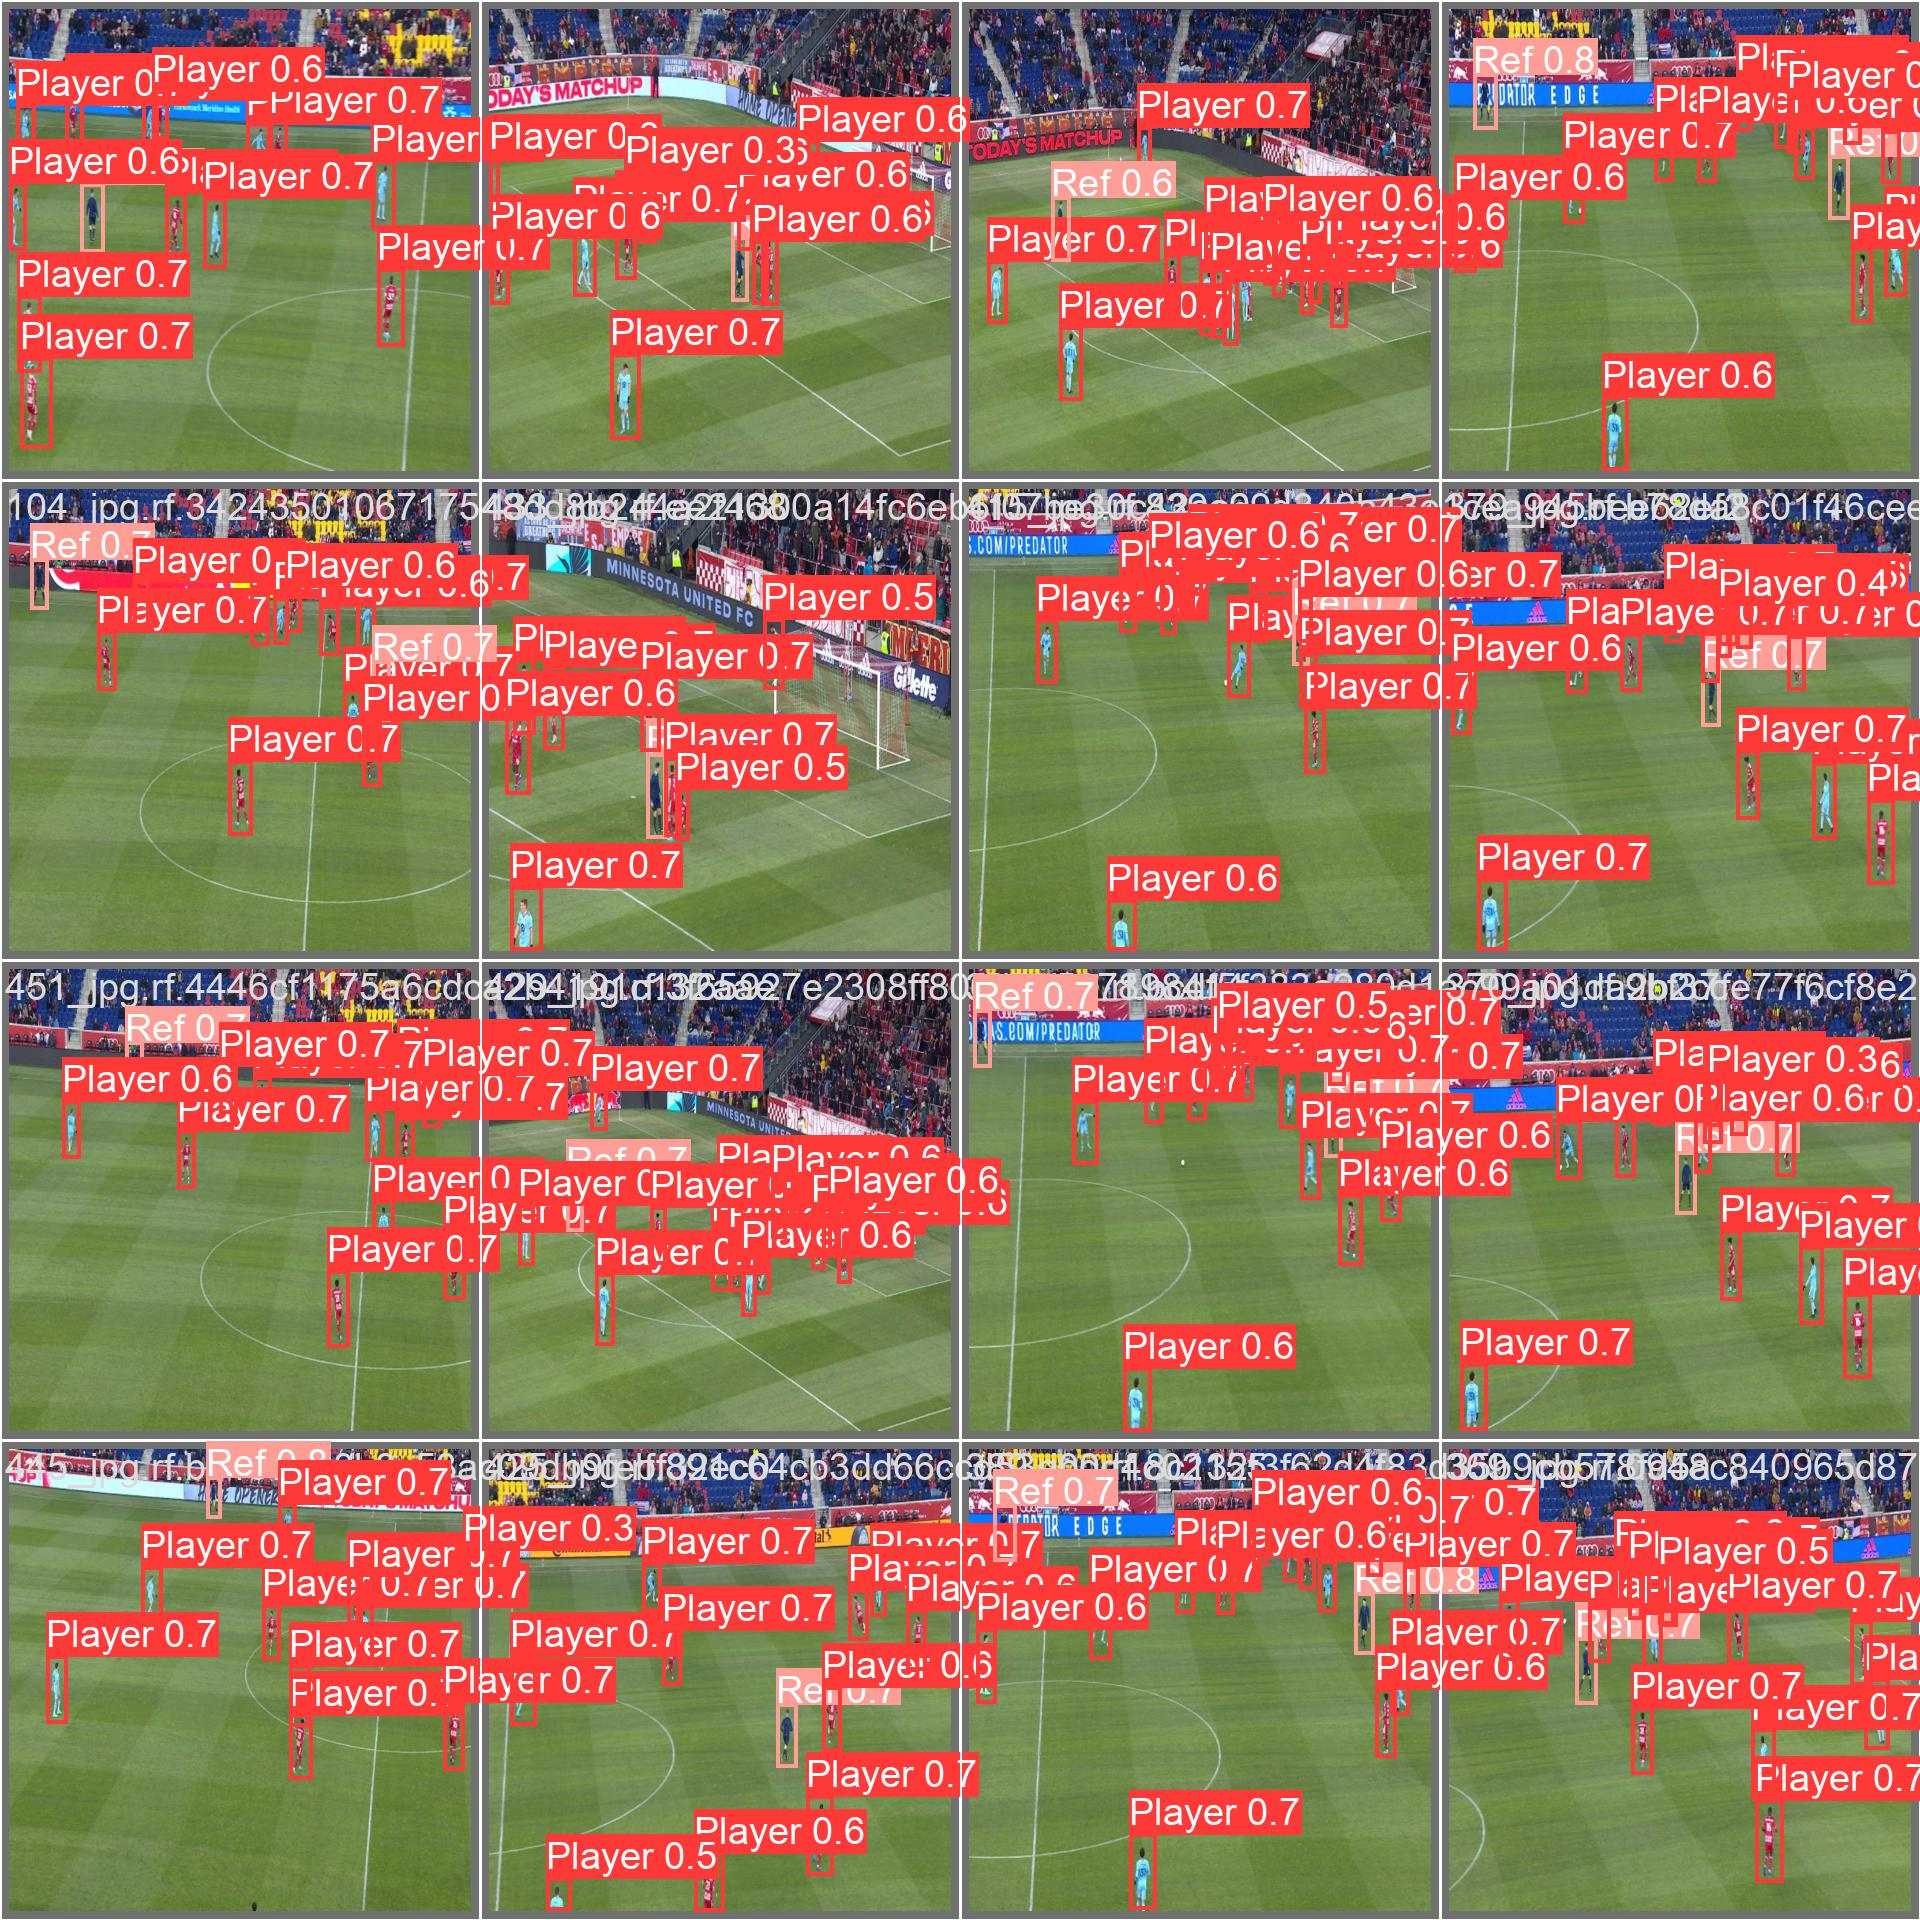

In [16]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=1000)

In [ ]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Deploy our model to roboflow

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")

This code is not needed for now. However, if you want to pull the model you created from roboflow, you can use this code

In [33]:
rf = Roboflow(api_key="YOUR API KEY")
project = rf.workspace("fikretulus").project("football-players-detection-bjzew")
model = project.version("3").model

loading Roboflow workspace...
loading Roboflow project...


Let's try the model on an image.

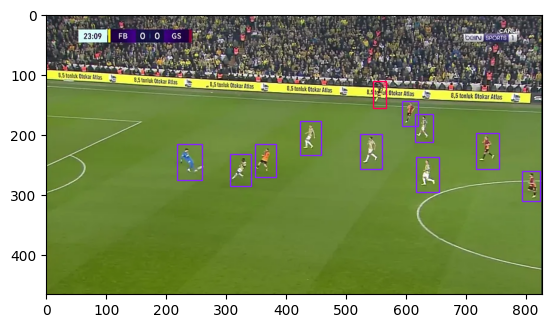

In [34]:
model.confidence = 50
model.overlap = 25

prediction = model.predict("/content/1_mJUtO84rxVhUU2RYVNyTAA.png")
prediction.plot()

It looks very successful. Still, it is worth trying it on a video.

In [35]:
!yolo detect predict model = {HOME}/runs/detect/train/weights/best.pt source = "/content/video.mp4" save = True

2023-08-01 20:31:28.875893: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-01 20:31:29.858686: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs
video 1/1 (1/364) /content/video.mp4: 448x800 12 Players, 1 Ref, 59.8ms
video 1/1 (2/364) /content/video.mp4: 448x800 12 Players, 4 Refs, 6.7ms
video 1/1 (3/364) /content/video.mp4: 448x800 11 Players, 4 Refs, 6.7ms
video 1/1 (4/364) /content/video.mp4: 448x800 11 Players, 5 Refs, 9.3ms
video 1/1 (5/364) /content/video.mp4: 448x800 11 Players, 5 Refs, 6.8ms
video 1/1 (6/364) /conte

In [36]:
!!ffmpeg -i {"/content/runs/detect/predict2/video.mp4"} -vcodec libx264 {"final.mp4"}

['ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers',
 '  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)',
 '  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-lib